# Inputs and irr at the regions level
In this model, we have inputs $\iota_t$ that goes into a given region. These inputs produce an output $\omega_t$. We want to analylize the following equations
$$
\sum_{t=0}^T\iota_t\left(\frac{1}{1+i}\right)^t=\sum_{t^\prime=0}^{T^\prime}\omega_t\left(\frac{1}{1+i}\right)^{t^\prime}
$$
where the first summation goes over all inputs both excitatory and inhibitory, and the second summations over all spikes in a given event. In particular we would like to estimate the value of $i$

Spikes in a region comes in trains. Therefore, an event is define as the timestep after the last train of the previous event to the last timestep of the current train.

In [1]:
%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set(style='whitegrid')

In [4]:
df = pd.read_csv('Firing/2015-11-27_13-39-21', index_col='time', names= ['time', 'neuron', 'one'])

In [5]:
df.head()

,neuron,one
time,,
20,6999,1
21,3913,1
30,3915,1
39,6998,1
41,3917,1


In [7]:
regions = pd.read_csv('Region/2015-11-27_13-39-21', index_col='neuron', names=['neuron', 'region'])

In [8]:
firing_and_regions = pd.merge(df, regions, left_on='neuron', right_index=True)
firing_and_regions.head()

,neuron,one,region
time,,,
20,6999,1,123
139,6999,1,123
186,6999,1,123
252,6999,1,123
772,6999,1,123


In [9]:
firing_and_regions.sort_index(inplace=True)

In [10]:
firing_and_regions.index = pd.to_datetime(firing_and_regions.index, unit='ms')

In [11]:
lowerLimit = pd.to_datetime(11, unit='s')
firing_and_regions = firing_and_regions[lowerLimit:]

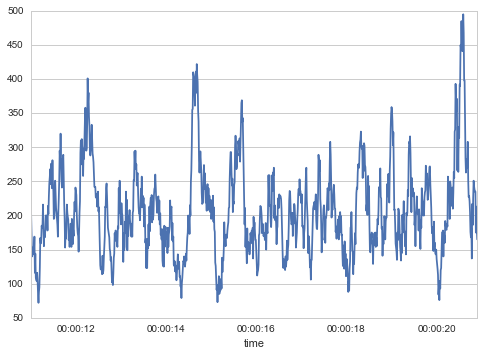

In [12]:
firing_and_regions.one.resample('10ms', how='sum').plot()

In [13]:
resampled_regions = firing_and_regions.groupby('region').one.resample('10ms', how='sum')

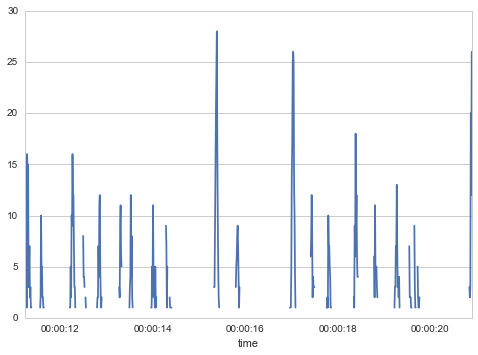

In [14]:
resampled_regions[2].plot()

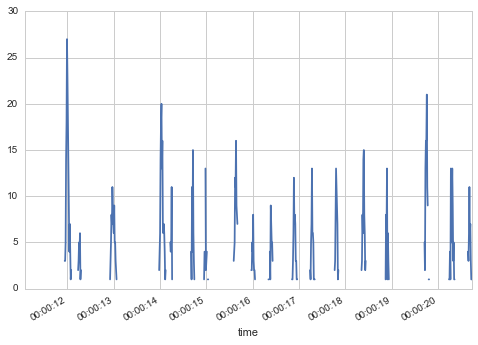

In [15]:
resampled_regions[3].plot()

In [16]:
most_active = resampled_regions.sum(level=0).sort_values(ascending=False)
most_active.head()

region
120    1429
72     1371
159    1355
35     1350
145    1349
dtype: float64

In [17]:
inputData = pd.read_csv('Input/2015-11-27_13-39-21', index_col='time', names= ['time', 'source', 'destination', 'inhibitor'])

In [18]:
inputData['inhibitor'] = inputData.inhibitor.astype('bool')

In [19]:
inputData.index = pd.to_datetime(inputData.index, unit='ms')

In [20]:
inputData = inputData[lowerLimit:]

In [21]:
inputs_and_regions = pd.merge(inputData, regions, left_on='source', right_index=True)
inputs_and_regions.head()

,source,destination,inhibitor,region
time,,,,
1970-01-01 00:00:11.000,6513,1996,True,63
1970-01-01 00:00:11.001,6513,2010,True,63
1970-01-01 00:00:11.002,6513,6512,True,63
1970-01-01 00:00:11.002,6513,2012,True,63
1970-01-01 00:00:11.002,6513,1995,True,63


In [22]:
inputs_and_regions['source_region'] = inputs_and_regions.region
inputs_and_regions = inputs_and_regions.drop('region', axis=1)

In [23]:
inputs_and_regions = pd.merge(inputs_and_regions, regions, left_on='destination', right_index=True)
inputs_and_regions.head()

,source,destination,inhibitor,source_region,region
time,,,,,
1970-01-01 00:00:11.000,6513,1996,True,63,63
1970-01-01 00:00:11.017,6513,1996,True,63,63
1970-01-01 00:00:11.483,6513,1996,True,63,63
1970-01-01 00:00:12.172,6513,1996,True,63,63
1970-01-01 00:00:12.176,6513,1996,True,63,63


In [24]:
inputs_and_regions['destination_region'] = inputs_and_regions.region
inputs_and_regions = inputs_and_regions.drop('region', axis=1)

In [25]:
inputs_and_regions['efective_input'] = 1*(1-inputs_and_regions.inhibitor) -1*inputs_and_regions.inhibitor
inputs_and_regions.head()

,source,destination,inhibitor,source_region,destination_region,efective_input
time,,,,,,
1970-01-01 00:00:11.000,6513,1996,True,63,63,-1
1970-01-01 00:00:11.017,6513,1996,True,63,63,-1
1970-01-01 00:00:11.483,6513,1996,True,63,63,-1
1970-01-01 00:00:12.172,6513,1996,True,63,63,-1
1970-01-01 00:00:12.176,6513,1996,True,63,63,-1


In [26]:
inter_region = inputs_and_regions[inputs_and_regions.source_region!= inputs_and_regions.destination_region]

In [27]:
resampled_input_regions = inter_region.groupby('destination_region').efective_input.resample('10ms', how='sum')

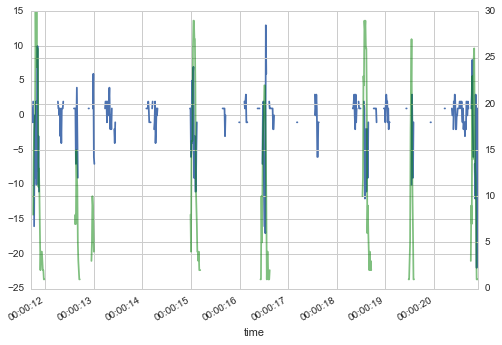

In [28]:
index = resampled_input_regions[120].index.searchsorted("1970-01-01 00:00:11.710")
ax = resampled_input_regions[120].ix[resampled_input_regions[120].index[index]:].plot()
resampled_regions[120].plot(color='g', ax=ax.twinx(), alpha=0.5)

In [29]:
def compute_intervals(region_activity):
    activity = region_activity.fillna(0)
    prev = 0
    intervals = []
    splits = np.append(np.where(np.diff(activity >= 3))[0],activity.count()+1)+1
    for split in splits:
        interval = np.arange(0,activity.size,1)[prev:split]
        if activity.ix[interval].mean() > 3:
            intervals.append(activity.ix[interval].index)
        prev = split
    return intervals

In [30]:
def irr(values):
    res = np.roots(values[::-1])
    mask = (res.imag == 0) & (res.real > 0)
    if res.size == 0 or res[mask].size == 0:
        return np.nan
    res = res[mask].real
    # NPV(rate) = 0 can have more than one solution so we return
    # only the solution closest to zero.
    rate = 1.0/res - 1
    rate = rate.item(np.argmin(np.abs(rate)))
    return rate

In [41]:
def compute_irr(region, payments):
    fullPayments = (region.ix[payments.index].fillna(0) - payments)
    return irr(fullPayments)

In [46]:
def compute_all_irr(regions, inputs):
    intervals = compute_intervals(regions)
    irrs = []
    min_delta = pd.to_timedelta('100ms')
    for i in range(1, len(intervals)):
        first, last = intervals[i-1].max(), intervals[i].max()
        activation = regions[intervals[i]]
        if last - first > min_delta and activation.max() > 20:
            payments = inputs[first:last]
            i = compute_irr(activation, payments)
            irrs.append(i)
    return irrs

In [32]:
resampled_regions = resampled_regions.fillna(0)

In [33]:
resampled_input_regions = resampled_input_regions.fillna(0)

In [36]:
def compute_irr_and_activity():
    regions_to_irr = {}
    for region, item in most_active.iteritems():
        irrs = compute_all_irr(resampled_regions[region], resampled_input_regions[region])
        regions_to_irr[region] = np.mean(np.extract(~np.isnan(irrs), irrs))
    regions_to_irr = pd.Series(regions_to_irr)
    return pd.DataFrame({'irr': regions_to_irr, 'activity': most_active}, index= most_active.index)

In [42]:
irr_and_activity = compute_irr_and_activity()
irr_and_activity.head()

,activity,irr
region,,
120,1429,0.029902
72,1371,0.023575
159,1355,-0.485006
35,1350,2.946208
145,1349,0.048595


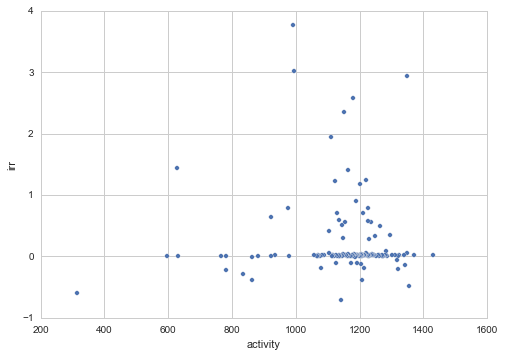

In [43]:
irr_and_activity.plot(kind='scatter', x='activity', y='irr')